In [1]:
import pyedflib
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.signal import butter, filtfilt

In [20]:
class EDFFile:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file_handle = None
        self.signal_headers = None
        self.sample_frequency = None
        self.raw_signals = []
        self.filtered_signals = []
        self.annotations = []
        
    def load_raw_signals(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)
            
        num_signals = self.file_handle.signals_in_file
        
        for i in range(num_signals):
            signal_buffer = self.file_handle.readSignal(i)
            self.raw_signals.append(signal_buffer)
    
    def load_signal_headers(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)

        self.signal_headers = self.file_handle.getSignalHeaders()

    def load_annotations(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)
        
        self.annotations = self.file_handle.readAnnotations()

    def load_sample_frequency(self):
        if self.file_handle is None:
            self.file_handle = pyedflib.EdfReader(self.file_path)
        
        self.sample_frequency = self.file_handle.getSampleFrequencies()[0]

    def butterworth_filter(self, signal, cutoff, order:int=3, f_type='low'):
        nyquist = 0.5 * self.sample_frequency
        normalized_cutoff = cutoff / nyquist
        b, a = butter(order, normalized_cutoff, btype=f_type, analog=True)
        
        return filtfilt(b, a, signal)

    # def filter_signals(self, filter_func, signal_labels):
    #     butterworth_lowpass = filter(lambda t: t[0].split()[0] in ['BI', 'Atmung/Respiration'], self.raw_signals)
    #     butterworth_lowpass_filtered = [(label, filter_func(signal, 15, 3, 'low')) 
    #                                     for label, signal in butterworth_lowpass]

    #     butterworth_highpass = filter(lambda t: t[0].split()[0] in ['EMG'], self.raw_signals)
    #     butterworth_highpass_filtered = [(label, filter_func(signal, 15, 3, 'high')) 
    #                                     for label, signal in butterworth_highpass]

    #     self.filtered_signals = butterworth_highpass_filtered + butterworth_lowpass_filtered
    
    def filter_signals(self, func:dict, signal_labels=['BI', 'Atmung/Respiration']):
        signals = filter(lambda l : l[0]["label"].split()[0] in signal_labels, 
                         zip(self.signal_headers, self.raw_signals))
        
        return [func["function"](signal, func["cutoff"], headers["sample_rate"], func["order"], func["f_type"])
                for headers, signal in signals]
        
    def close(self):
        if self.file_handle is not None:
            self.file_handle.close()
            self.file_handle = None

In [21]:
def butterworth_filter(signal, cutoff, fs, order:int=3, f_type='low'):
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff / nyquist
    b, a = butter(order, normalized_cutoff, btype=f_type, analog=True)
    
    return filtfilt(b, a, signal)

In [22]:
def read_files_from_dir(directory: Path):
    extensions = ["edf", "bdf"]

    return [EDFFile(file.path) for file in os.scandir(directory) 
            if file.is_file() and file.name.endswith(tuple(extensions))]

In [23]:
directory = Path("data/edf/")
files = read_files_from_dir(directory)

for signal_file in files:
    signal_file.load_raw_signals()
    signal_file.load_signal_headers()
    signal_file.load_annotations()
    signal_file.load_sample_frequency()
    #signal_file.filter_signals()
    # # Accessing signal data:
    # for signal_name, signal_buffer in signal_file.signals:
    #     print(f'Signal: {signal_name}')
    #     print(f'Buffer: {signal_buffer}')
    #signal_file.close()

In [ ]:
for file in files:
    file.close()

In [34]:
filtered = files[0].filter_signals(func={"function": butterworth_filter, "order": 3, "cutoff": 15, "f_type": "low"})

In [32]:
files[0].raw_signals[2]

array([-3.29887007e+00,  4.98973220e+00,  4.99647129e+00, ...,
        7.58485959e-06,  7.58485959e-06,  7.58485959e-06])

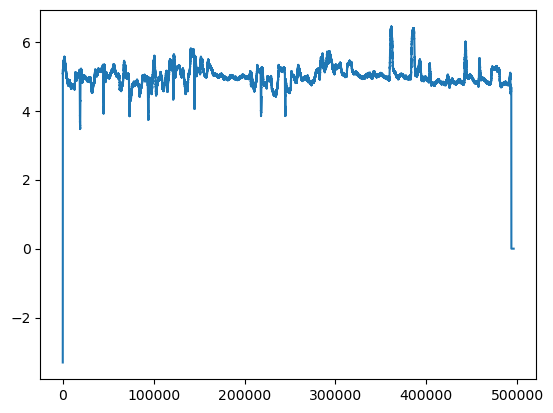

In [33]:
plt.plot(files[0].raw_signals[2])

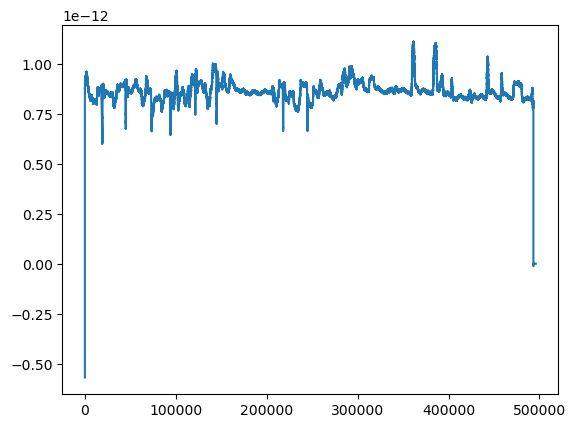

In [35]:
plt.plot(filtered[0])

In [ ]:
# Usage example
signal = files[0].raw_signals[2][1]
fs = files[0].file_handle.getSampleFrequencies()[0]
filtered_signal = files[0].apply_butterworth(signal, 15, 3, 'low') # Let it be dynamic - integrate with GUI

In [ ]:
plt.plot(files[3].raw_signals[-2][1])

In [ ]:
plt.plot(files[3].filtered_signals[-1][1])

# Save EDF file file.name + _filtered.edf

In [ ]:
from pyedflib import highlevel

# write an edf file
signals = []
channel_names = []
for channel_name, signal, fs in butterworth_highpass_filtered + butterworth_lowpass_filtered:
    channel_names.append(channel_name)
    signals.append(signal)

signal_headers = highlevel.make_signal_headers(channel_names, sample_frequency=fs)
header = highlevel.make_header(patientname='patient', gender='Female')
if highlevel.write_edf('edf_file_filtered.edf', signals, signal_headers, header):
    print("The file has been successfully saved.")
else:
    print("Something went wrong with the saving process.")

In [ ]:
t = EDFFile("edf_file_filtered.edf")

In [ ]:
plt.plot(t.signals[2][1])